In [23]:
import pandas as pd 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go



In [24]:
# Fake data for ANOVA 
np.random.seed(42)
data = {'Group 1': np.random.normal(loc=50, scale=10, size=45),
        'Group 2': np.random.normal(loc=55, scale=10, size=45),
        'Group 3': np.random.normal(loc=60, scale=10, size=45), 
        'Group 4': np.random.normal(loc=55, scale=10, size=45), 
        'Group 5': np.random.normal(loc=50, scale=10, size=45)}

df = pd.DataFrame(data)


In [25]:
df_melt = pd.melt(df, value_vars=['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5'], var_name='Groups', value_name='Values')
model = ols('Values ~ C(Groups)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq     df          F        PR(>F)
C(Groups)   3875.752528    4.0  10.312376  1.133602e-07
Residual   20670.929237  220.0        NaN           NaN


In [26]:
group_means = df_melt.groupby('Groups')['Values'].mean()
group_sems = df_melt.groupby('Groups')['Values'].sem()

group_stats = pd.DataFrame({
    'Group': group_means.index,
    'Mean': group_means.values,
    'SEM': group_sems.values
})

confidence_intervals = pd.DataFrame({
    'Lower Bound': group_means - 1.96 * group_sems,
    'Upper Bound': group_means + 1.96 * group_sems
})

confidence_intervals['Mean'] = group_means
confidence_intervals['SEM'] = group_sems

print(confidence_intervals)


         Lower Bound  Upper Bound       Mean       SEM
Groups                                                
Group 1    45.119485    50.555665  47.837575  1.386780
Group 2    52.453961    57.918561  55.186261  1.394031
Group 3    56.553418    62.158341  59.355879  1.429827
Group 4    53.914442    59.554825  56.734633  1.438873
Group 5    47.673210    53.819764  50.746487  1.567999


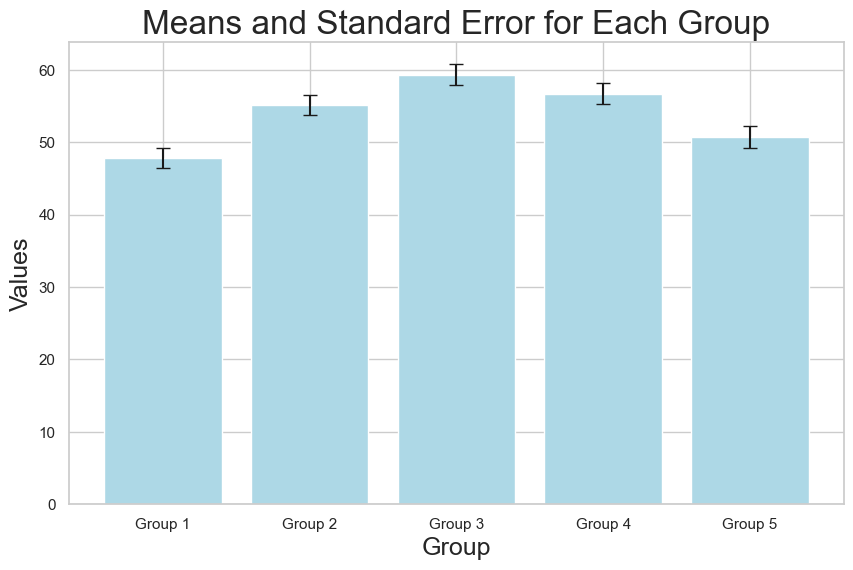

In [38]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.bar(group_stats['Group'], group_stats['Mean'], yerr=group_stats['SEM'], capsize=5, color='lightblue')
plt.title('Means and Standard Error for Each Group', fontsize=24)
plt.xlabel('Group', fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.show()


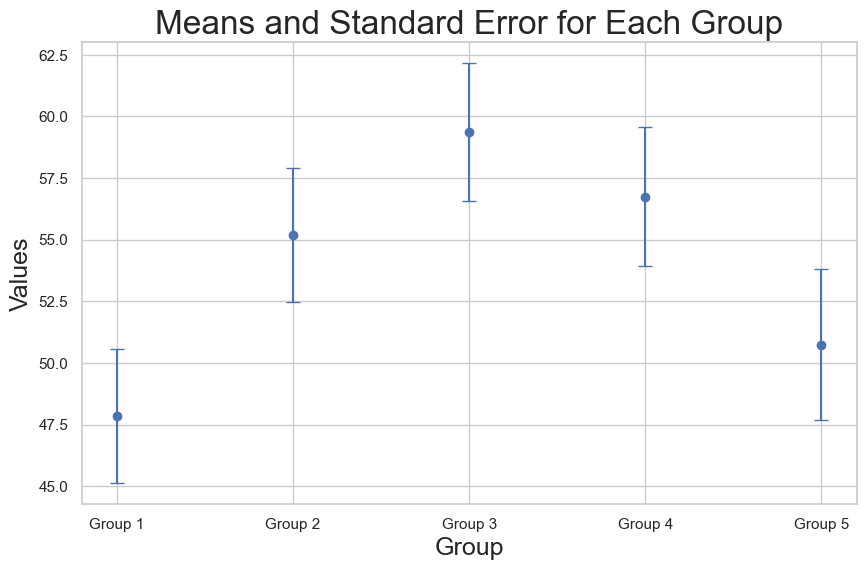

In [28]:
plt.figure(figsize=(10, 6))
plt.errorbar(x=confidence_intervals.index, y=confidence_intervals['Mean'], yerr=1.96 * confidence_intervals['SEM'], fmt='o', capsize=5)
plt.title('Means and Standard Error for Each Group', fontsize=24)
plt.xlabel('Group', fontsize=18)
plt.ylabel('Values', fontsize=18)
plt.grid(True)
plt.show()


In [29]:
# Fake data with two dependent variables for MANOVA 
np.random.seed(42)
data = {
    'Group': ['Group1']*30 + ['Group2']*30 + ['Group3']*30,
    'Outcome1': np.concatenate([np.random.normal(50, 10, 30), np.random.normal(55, 10, 30), np.random.normal(60, 10, 30)]),
    'Outcome2': np.concatenate([np.random.normal(30, 5, 30), np.random.normal(35, 5, 30), np.random.normal(40, 5, 30)]),
}

df = pd.DataFrame(data)


In [30]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('Outcome1 + Outcome2 ~ Group', data=df)
print(maov.mv_test())


                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0396 2.0000 86.0000 1043.4937 0.0000
         Pillai's trace  0.9604 2.0000 86.0000 1043.4937 0.0000
 Hotelling-Lawley trace 24.2673 2.0000 86.0000 1043.4937 0.0000
    Roy's greatest root 24.2673 2.0000 86.0000 1043.4937 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           Group          Value  Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
            Wilks' lambda 0.4210 4.0000 172.0000 23.2684 0.0000
           Pillai's trace 0.5797 4.0000 174.0000 17.7554 0.

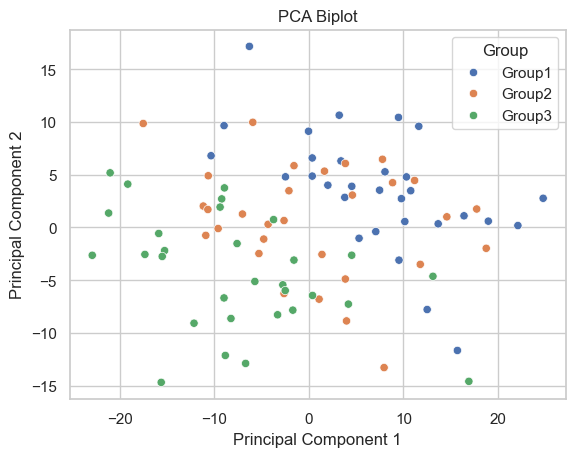

In [31]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df[['Outcome1', 'Outcome2']])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, df[['Group']]], axis = 1)

sns.scatterplot(x='PC1', y='PC2', hue='Group', data=finalDf)
plt.title('PCA Biplot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Group')
plt.show()


In [32]:
# 3X3 exploritory experimental design fake data 
np.random.seed(42)
data = {
    'Factor1': np.repeat(['Level1', 'Level2', 'Level3'], 30),
    'Factor2': np.tile(np.repeat(['Duration 1', 'Duration 2', 'Duration 3'], 10), 3),
    'Outcome1': np.random.normal(0, 1, 90),
    'Outcome2': np.random.normal(5, 2, 90),
    'Outcome3': np.random.normal(10, 3, 90)
}

df = pd.DataFrame(data)
df.head()

,Factor1,Factor2,Outcome1,Outcome2,Outcome3
0,Level1,Duration 1,0.496714,5.194155,11.877002
1,Level1,Duration 1,-0.138264,6.937290,7.428527
2,Level1,Duration 1,0.647689,3.595894,6.787323
3,Level1,Duration 1,1.523030,4.344676,11.447417
4,Level1,Duration 1,-0.234153,4.215784,9.329612


In [33]:
summary_df = df.groupby(['Factor1', 'Factor2']).agg({
    'Outcome1': ['mean', 'sem'],
    'Outcome2': ['mean', 'sem'],
    'Outcome3': ['mean', 'sem']
}).reset_index()

summary_df.columns = [' '.join(col).strip() for col in summary_df.columns.values]

summary_df

,Factor1,Factor2,Outcome1 mean,Outcome1 sem,Outcome2 mean,Outcome2 sem,Outcome3 mean,Outcome3 sem
0,Level1,Duration 1,0.448061,0.228635,4.701617,0.412681,9.312819,0.760388
1,Level1,Duration 2,-0.790658,0.238855,4.901125,0.548379,9.436553,0.668641
2,Level1,Duration 3,-0.221844,0.257377,5.275748,0.758064,11.840959,1.318174
3,Level2,Duration 1,-0.310107,0.362155,5.139848,0.731653,10.702725,0.630255
4,Level2,Duration 2,-0.252822,0.284797,4.407407,0.633362,9.726636,1.240194
5,Level2,Duration 3,0.199441,0.223097,4.882996,0.620297,10.002966,1.063290
6,Level3,Duration 1,-0.015057,0.278398,5.306550,0.542271,9.991255,0.844486
7,Level3,Duration 2,-0.047736,0.428397,5.649240,0.615792,10.775707,1.130447
8,Level3,Duration 3,0.101447,0.233837,5.716930,0.687580,7.942151,1.193910


In [34]:
maov = MANOVA.from_formula('Outcome1 + Outcome2 + Outcome3 ~ Factor1 * Factor2', data=df)
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.3638 3.0000 79.0000 46.0488 0.0000
           Pillai's trace 0.6362 3.0000 79.0000 46.0488 0.0000
   Hotelling-Lawley trace 1.7487 3.0000 79.0000 46.0488 0.0000
      Roy's greatest root 1.7487 3.0000 79.0000 46.0488 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
         Factor1         Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9389 6.0000 158.0000  0.8440 0.5377
          Pillai's trace 0.0613 6.0000 160.0000  0.8432 0.5383
  Hotelling

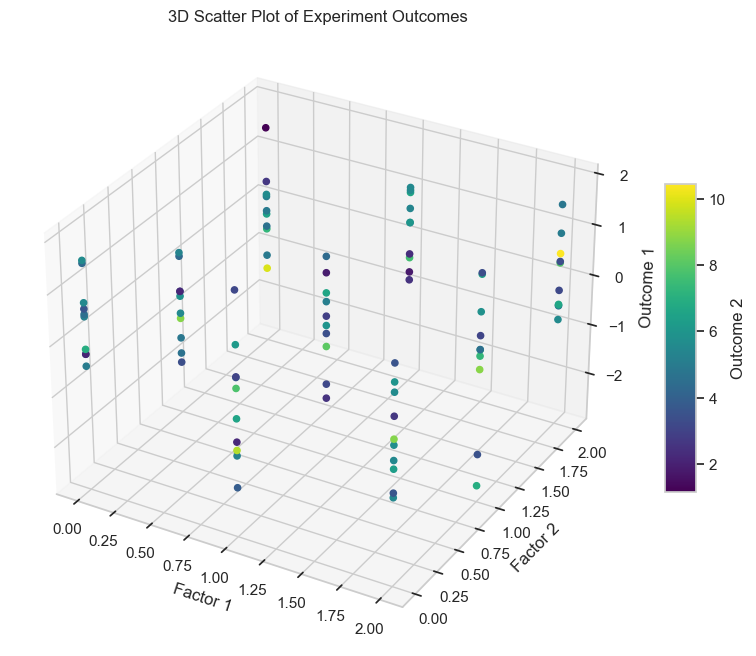

In [35]:
df['Factor1_id'] = df['Factor1'].astype('category').cat.codes
df['Factor2_id'] = df['Factor2'].astype('category').cat.codes

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['Factor1_id'], df['Factor2_id'], df['Outcome1'], c=df['Outcome2'], cmap='viridis', depthshade=False)
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Outcome 1')

color_bar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
color_bar.set_label('Outcome 2')

plt.title('3D Scatter Plot of Experiment Outcomes')
plt.show()


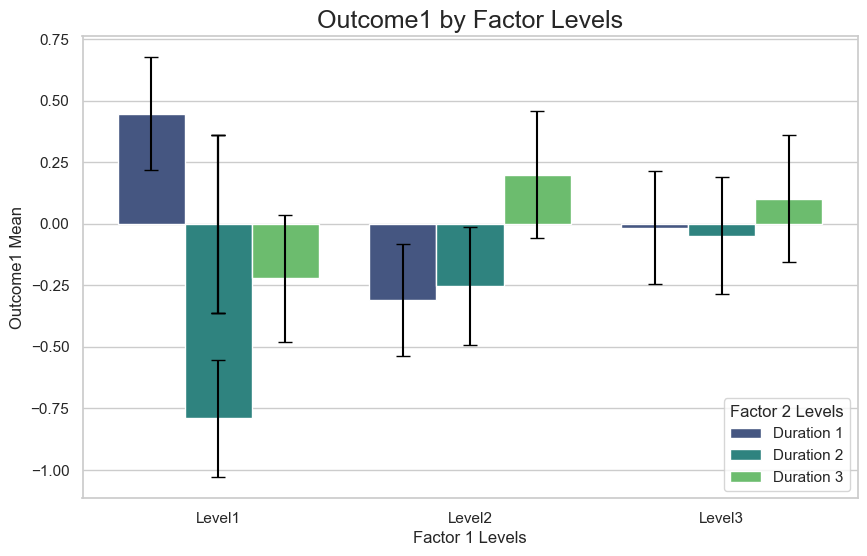

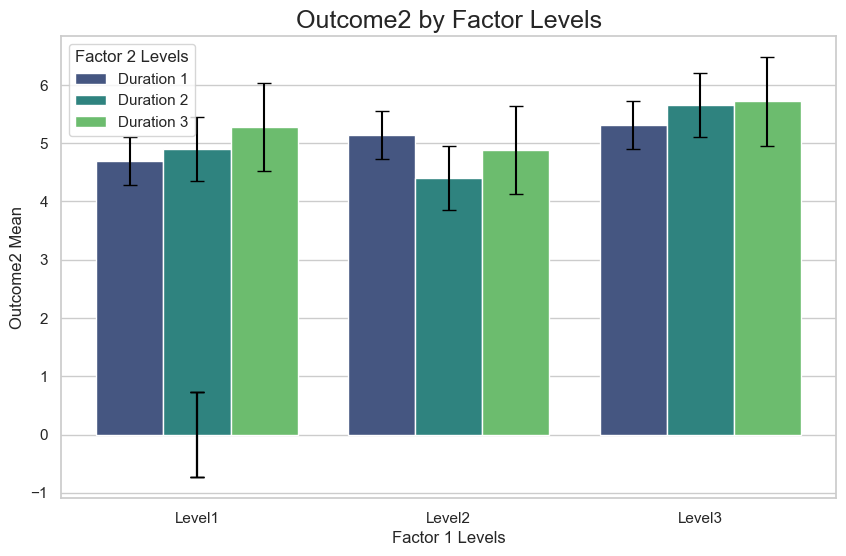

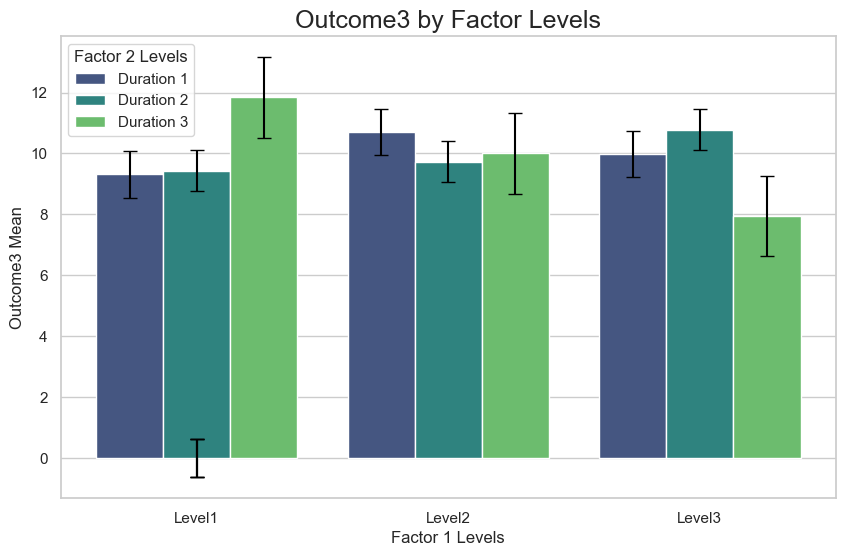

In [36]:
sns.set(style="whitegrid")
def plot_outcome(data, outcome):
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x='Factor1', y=f'{outcome} mean', hue='Factor2', data=data, capsize=.1, palette='viridis')
    for i, bar in enumerate(barplot.patches):
        sem = data.loc[i//3, f'{outcome} sem']
        barplot.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(), yerr=sem, color='black', capsize=5)

    plt.title(f'{outcome} by Factor Levels', fontsize=18)
    plt.xlabel('Factor 1 Levels')
    plt.ylabel(f'{outcome} Mean')
    plt.legend(title='Factor 2 Levels')
    plt.show()

plot_outcome(summary_df, 'Outcome1')
plot_outcome(summary_df, 'Outcome2')
plot_outcome(summary_df, 'Outcome3')


In [37]:
# 3D interactive scatter plot
fig = go.Figure()

factor1_ids = df['Factor1'].astype('category').cat.codes
factor2_ids = df['Factor2'].astype('category').cat.codes

fig.add_trace(go.Scatter3d(
    x=df['Outcome1'],
    y=df['Outcome2'],
    z=df['Outcome3'],
    mode='markers',
    marker=dict(
        size=5,
        color=factor1_ids,                
        colorscale='Viridis',             
        opacity=0.8
    ),
    text='Factor 1: ' + df['Factor1'] + ', Factor 2: ' + df['Factor2']  
))

fig.update_layout(
    title='3D Scatter Plot of Experimental Outcomes',
    scene=dict(
        xaxis_title='Outcome 1',
        yaxis_title='Outcome 2',
        zaxis_title='Outcome 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()
